# Main Library

In [1]:
# Reading Data
import pandas as pd
import numpy as np
import os, string, re, nltk

# Data Preprocessing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Building Model
import tensorflow.keras as k
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# Reading Data

In [2]:
data = pd.read_csv(r'D:\Courses language programming\LLM - Transformer - NLP\NLP - Complete Course\Projects For NLP\Data\Spotify Reviews\spotify_reviews.csv')
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,437314fe-1b1d-4352-abea-12fec30fce58,Rajib Das,It's good,4,0,NaN,2024-05-09 16:28:13,NaN
1,4933ad2c-c70a-4a84-957d-d405439b2e0f,Mihaela Claudia Neagu,"I love this app so much, I've been using Spoti...",5,0,8.9.38.494,2024-05-09 16:27:18,8.9.38.494
2,1ab275fb-59bf-42c7-88ef-b85901f0445e,JONATHAN GRACIA,Perfect,5,0,8.9.36.616,2024-05-09 16:27:03,8.9.36.616
3,b38406eb-7b11-4ceb-a45c-d7f28fb5d382,Cam Rempel,Best all around music streaming app I have use...,5,0,8.9.38.494,2024-05-09 16:26:19,8.9.38.494
4,7be7999d-4cb6-47b9-8414-d7bdaa9df578,Your clowness (Her Clowness),Are y'all fr gatekeeping the play button on so...,1,0,8.9.38.494,2024-05-09 16:26:14,8.9.38.494


In [3]:
data.isnull().sum()

reviewId                   0
userName                   4
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    5768
at                         0
appVersion              5768
dtype: int64

In [4]:
len(data['thumbsUpCount'].value_counts())

828

In [5]:
data['score'].value_counts(), len(data['score'].value_counts())

(1    35060
 2    13846
 5    13568
 3    12019
 4     9672
 Name: score, dtype: int64,
 5)

# Drop Some col

In [6]:
data = data.drop(columns=['reviewId', 'userName', 'reviewCreatedVersion', 'at', 'appVersion', 'thumbsUpCount'], axis=1)

In [7]:
data.head()

,content,score
0,It's good,4
1,"I love this app so much, I've been using Spoti...",5
2,Perfect,5
3,Best all around music streaming app I have use...,5
4,Are y'all fr gatekeeping the play button on so...,1


In [8]:
punc = list(string.punctuation)
lemma = WordNetLemmatizer()
ps = PorterStemmer()
sw = stopwords.words('english')

In [9]:
def preprocessing(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.split()
    text = ' '.join([lemma.lemmatize(word) for word in text if (word not in punc) or (word not in sw)])
    return text

In [10]:
data['content'] = data['content'].apply(preprocessing)
data.head()

,content,score
0,it s good,4
1,i love this app so much i ve been using spotif...,5
2,perfect,5
3,best all around music streaming app i have use...,5
4,are y all fr gatekeeping the play button on song,1


# Feature Extraction

In [11]:
X = data['content']

tfidf = TfidfVectorizer()
new_x = tfidf.fit_transform(X)
new_x[0]

<1x29406 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [15]:
new_x[0]

<1x29406 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

# Tokenization

In [16]:
tokenize = Tokenizer(oov_token="<OOV>")
tokenize.fit_on_texts(X)
word_index = tokenize.word_index

data_sequance = tokenize.texts_to_sequences(X)
maxlen = max([len(seq) for seq in data_sequance])
# Padding_Sequances
data_padding = pad_sequences(data_sequance, maxlen=maxlen, padding="pre", truncating="pre")

input_length = max(len(seq) for seq in data_sequance)
vocabulary_size = len(word_index) + 1

# Splitting Into Training & Testing

In [21]:
data['score'].value_counts()

1    35060
2    13846
5    13568
3    12019
4     9672
Name: score, dtype: int64

In [19]:
data['new_score'] = data['score'].apply(lambda x: x-1)

In [22]:
data.head()

,content,score,new_score
0,it s good,4,3
1,i love this app so much i ve been using spotif...,5,4
2,perfect,5,4
3,best all around music streaming app i have use...,5,4
4,are y all fr gatekeeping the play button on song,1,0


In [23]:
data['new_score'].value_counts()

0    35060
1    13846
4    13568
2    12019
3     9672
Name: new_score, dtype: int64

In [24]:
label = k.utils.to_categorical(data['new_score'], 5)

In [25]:
label[1], data['score']

(array([0., 0., 0., 0., 1.], dtype=float32),
 0        4
 1        5
 2        5
 3        5
 4        1
         ..
 84160    3
 84161    4
 84162    3
 84163    4
 84164    1
 Name: score, Length: 84165, dtype: int64)

In [26]:
x_train, x_test, y_train, y_test = train_test_split(new_x, data['new_score'], train_size=0.7)
x_train1, x_test1, y_train1, y_test1 = train_test_split(data_padding, label, train_size=0.7)

# Building Model

In [27]:
model_nb = MultinomialNB()
model_nb.fit(x_train, y_train)

print('the score of training data is ', model_nb.score(x_train, y_train))
print('the score of testing data is ', model_nb.score(x_test, y_test))

the score of training data is  0.4882797250275821
the score of testing data is  0.4796039603960396


In [28]:
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)

print('the score of training data is ', model_rf.score(x_train, y_train))
print('the score of testing data is ', model_rf.score(x_test, y_test))

the score of training data is  0.9994228973945515
the score of testing data is  0.5165148514851485


# Building Model ==> Neural Network

In [29]:
model = k.models.Sequential(
    [
        k.layers.Embedding(vocabulary_size, 100, input_length=maxlen),
        k.layers.GlobalAveragePooling1D(),
        k.layers.Dense(128, activation="relu"),
        k.layers.Dense(24, activation="relu"),
        k.layers.Dense(5, activation="softmax")
    ])
model.compile(optimizer="adam", loss=k.losses.CategoricalCrossentropy(), metrics=["accuracy"])

In [23]:
history = model.fit(x_train1, y_train1, epochs=10, validation_data=(x_test1, y_test1), verbose=2)

Epoch 1/10
1842/1842 - 9s - loss: 1.0031 - accuracy: 0.5924 - val_loss: 1.0369 - val_accuracy: 0.5782 - 9s/epoch - 5ms/step
Epoch 2/10
1842/1842 - 9s - loss: 0.9754 - accuracy: 0.6036 - val_loss: 1.0357 - val_accuracy: 0.5813 - 9s/epoch - 5ms/step
Epoch 3/10
1842/1842 - 9s - loss: 0.9579 - accuracy: 0.6106 - val_loss: 1.0196 - val_accuracy: 0.5845 - 9s/epoch - 5ms/step
Epoch 4/10
1842/1842 - 9s - loss: 0.9424 - accuracy: 0.6171 - val_loss: 1.0180 - val_accuracy: 0.5870 - 9s/epoch - 5ms/step
Epoch 5/10
1842/1842 - 9s - loss: 0.9270 - accuracy: 0.6245 - val_loss: 1.0167 - val_accuracy: 0.5847 - 9s/epoch - 5ms/step
Epoch 6/10
1842/1842 - 9s - loss: 0.9102 - accuracy: 0.6331 - val_loss: 1.0404 - val_accuracy: 0.5714 - 9s/epoch - 5ms/step
Epoch 7/10
1842/1842 - 9s - loss: 0.8928 - accuracy: 0.6392 - val_loss: 1.0369 - val_accuracy: 0.5865 - 9s/epoch - 5ms/step
Epoch 8/10
1842/1842 - 9s - loss: 0.8746 - accuracy: 0.6465 - val_loss: 1.0442 - val_accuracy: 0.5762 - 9s/epoch - 5ms/step
Epoch 9/

In [26]:
import matplotlib.pyplot as plt

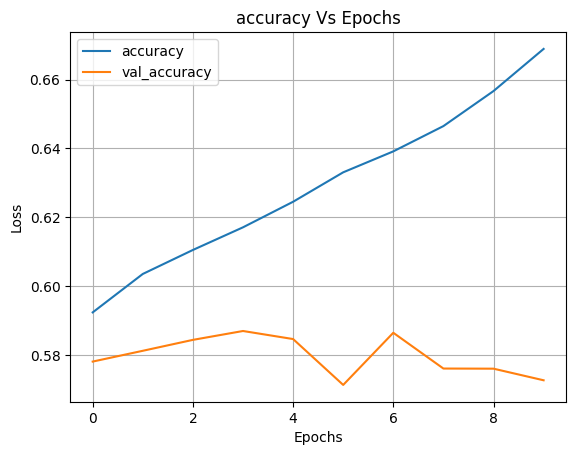

In [31]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("accuracy Vs Epochs")

plt.legend()
plt.grid()

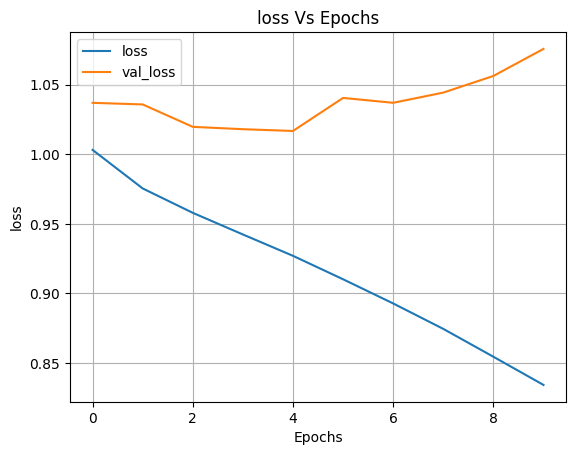

In [33]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")

plt.xlabel("Epochs")
plt.ylabel("loss")

plt.title("loss Vs Epochs")

plt.legend()
plt.grid()